In [1]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
print(os.getcwd())
RANDOM_SEED = 1
NUM_CLASSES = 5
dataset = 'new_keypoint.csv'
model_save_path = 'new_keypoint_classifier.hdf5'

c:\Users\thana\Desktop\TheShit\mbse_athome\mbse_code\atHome_code\model\keypoint_classifier


In [12]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.8, random_state=RANDOM_SEED)

### Model creation

In [2]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

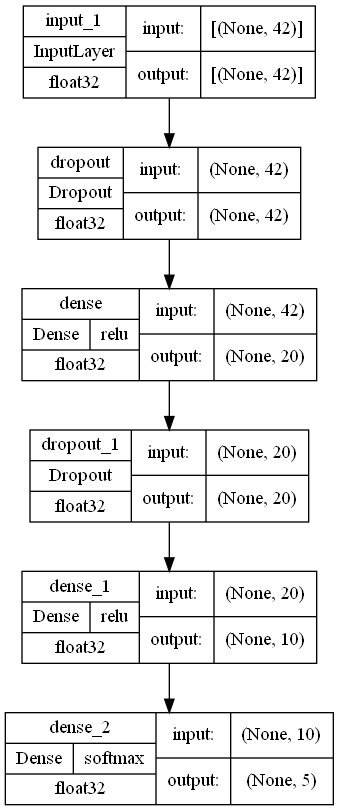

In [4]:
model_img_file = 'model.png'
tf.keras.utils.plot_model(model, to_file=model_img_file, 
                          show_shapes=True, 
                          show_layer_activations=True, 
                          show_dtype=True,
                          show_layer_names=True )

In [16]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
Total params: 1,125
Trainable params: 1,125
Non-trainable params: 0
_________________________________________________________________


In [17]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=3, save_weights_only=False)
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [18]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### Train

In [19]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
46/48 [===========================>..] - ETA: 0s - loss: 1.6436 - accuracy: 0.1892
Epoch 1: saving model to new_keypoint_classifier.hdf5
48/48 [==============================] - 1s 12ms/step - loss: 1.6420 - accuracy: 0.1914 - val_loss: 1.5722 - val_accuracy: 0.3108
Epoch 2/1000
39/48 [=======================>......] - ETA: 0s - loss: 1.5750 - accuracy: 0.2654
Epoch 2: saving model to new_keypoint_classifier.hdf5
48/48 [==============================] - 0s 6ms/step - loss: 1.5734 - accuracy: 0.2673 - val_loss: 1.5307 - val_accuracy: 0.4057
Epoch 3/1000
41/48 [========================>.....] - ETA: 0s - loss: 1.5223 - accuracy: 0.3449
Epoch 3: saving model to new_keypoint_classifier.hdf5
48/48 [==============================] - 0s 6ms/step - loss: 1.5186 - accuracy: 0.3483 - val_loss: 1.4525 - val_accuracy: 0.4382
Epoch 4/1000
40/48 [========================>.....] - ETA: 0s - loss: 1.4526 - accuracy: 0.3783
Epoch 4: saving model to new_keypoint_classifier.hdf5
48/48 [=====

In [20]:
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

12/12 [==============================] - 0s 6ms/step - loss: 0.7192 - accuracy: 0.6992


In [21]:
model = tf.keras.models.load_model(model_save_path)

In [22]:
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 71ms/step
[2.7185699e-03 4.3150289e-05 8.9456135e-01 8.1699573e-02 2.0977302e-02]
2


### Analyze

48/48 [==============================] - 0s 2ms/step


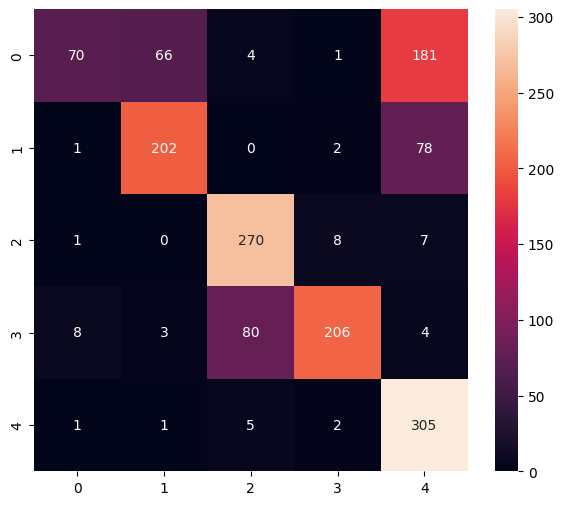

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.22      0.35       322
           1       0.74      0.71      0.73       283
           2       0.75      0.94      0.84       286
           3       0.94      0.68      0.79       301
           4       0.53      0.97      0.69       314

    accuracy                           0.70      1506
   macro avg       0.77      0.71      0.68      1506
weighted avg       0.77      0.70      0.67      1506



In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [24]:
model.save(model_save_path, include_optimizer=False)

In [25]:
tflite_save_path = 'new_keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\thana\AppData\Local\Temp\tmpuaxxzhwb\assets


6588

### Test

In [21]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])